In [27]:
# Recommendation: `conda install --channel conda-forge geopandas`
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import shapely
import json

In [28]:
def splits_to_regions_binary(row, splits):
    if splits is None:
        return 0
    if len(splits) == 0:
        return 0

    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

In [50]:
with open("../states.json", "r") as f:
    states = json.load(f)
state = "TX"
voting_precincts = gpd.read_file('../data/tx/texas_2016/')
n_districts = states[state]["NUM_OF_DISTRICTS"]
pop = states[state]["POPULATION"]
d_votes = states[state]["DEMOCRAT_VOTES"]
r_votes = states[state]["REPUBLICAN_VOTES"]
print(voting_precincts.columns)
voting_precincts.sample(n=1)

Index(['CNTYVTD', 'VTD', 'WHITE', 'OTHER', 'HISPANIC', 'TOTPOP', 'VAP',
       'BLACK', 'BLKHISP', 'WVAP', 'HISPVAP', 'BHVAP', 'BVAP', 'OTHVAP',
       'COUNTY', 'FIPS', 'PRES12R', 'PRES12D', 'SEN12R', 'SEN12D', 'TOTVR12',
       'TOTTO12', 'SEN14R', 'SEN14D', 'GOV14R', 'GOV14D', 'TOTVR14', 'TOTTO14',
       'PRES16D', 'PRES16R', 'TOTVR16', 'TOTTO16', 'USCD', 'SEND', 'HD',
       'AREA', 'PERIM', 'geometry'],
      dtype='object')


,CNTYVTD,VTD,WHITE,OTHER,HISPANIC,TOTPOP,VAP,BLACK,BLKHISP,WVAP,...,PRES16D,PRES16R,TOTVR16,TOTTO16,USCD,SEND,HD,AREA,PERIM,geometry
5039,2970008,0008,99.0,1.0,49.0,149.0,122.0,0.0,49.0,84.0,...,6,82,139,88,15,21,31,273,83,"POLYGON ((1175998.315 726896.590, 1175977.075 ..."


In [51]:
# voting_precincts = voting_precincts.to_crs("EPSG:4269")
# voting_precincts['GEOID20'] = voting_precincts['GEOID20'].astype(str)

print([x for x in voting_precincts.columns if "POP" in x.upper()])
print([x for x in voting_precincts.columns if "D" in x.upper()])
print(voting_precincts.shape)
# voting_precincts.sample(n=5)

['TOTPOP']
['CNTYVTD', 'VTD', 'PRES12D', 'SEN12D', 'SEN14D', 'GOV14D', 'PRES16D', 'USCD', 'SEND', 'HD']
(8941, 38)


In [31]:
voting_precincts['REPRESENTATIVE_POINT'] =  voting_precincts.representative_point() # https://gis.stackexchange.com/a/414263
voting_precincts['RP_LON'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
voting_precincts['RP_LAT'] = voting_precincts['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(voting_precincts.shape)
# voting_precincts.sample(n=5)

(9178, 75)


In [32]:
voting_precincts["Dem_Ratio"] = voting_precincts[d_votes]/(voting_precincts[d_votes] + voting_precincts[r_votes])
voting_precincts["Rep_Ratio"] = voting_precincts[r_votes]/(voting_precincts[d_votes] + voting_precincts[r_votes])
# voting_precincts.sample(n=5)

In [47]:
df = voting_precincts.copy()
n_districts = 1
n_split = 1
pop_col = pop
dem_col = d_votes
rep_col = r_votes

if n_districts % 2 == 0:
    part_a = n_districts/2
    part_b = n_districts/2
else:
    part_a = math.ceil(n_districts/2)
    part_b = math.floor(n_districts/2)

# Get Total Population
pop_total = df[pop_col].sum()

# Get Population Center
pop_center_LON = (df['RP_LON'] * df[pop_col]).sum()/pop_total
pop_center_LAT =  (df['RP_LAT'] * df[pop_col]).sum()/pop_total

# Re-center LAT/LON relative to the Population Center
df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

# Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


angle_ranges = []
df = df.sort_values('RECENTERED_ANGLE').reset_index(drop=True).reset_index()
df['old_index'] = df['index']
df.drop('index', axis=1, inplace=True)

curr_sum = 0 # Population Sum, as you iterate through, drop the ith value before the next iteration
j = 0 # Where the curr range ends at, gets incremented and gets reset after hitting max.
for i, row in df.iterrows():
    while curr_sum < (part_a)/(part_a+part_b)*pop_total:
        curr_sum += df.loc[j, pop_col] 
        j += 1

        if j == len(df):
            j = 0


    df[f'SPLIT_{n_split}'] = 0
    if i <= j:
        df.loc[(df['old_index'] >= i) & (df['old_index'] <= j), f'SPLIT_{n_split}'] = 1
    else:
        df.loc[(df['old_index'] <= i) & (df['old_index'] >= j), f'SPLIT_{n_split}'] = 1

    # if i <= j:
    #     df[f'SPLIT_{n_split}'] = df['index'].apply(lambda x: 1 if i <= x <= j else 0)
    # elif i >= j:
    #     df[f'SPLIT_{n_split}'] = df['index'].apply(lambda x: 1 if ((x >= i) or (x <= j)) else 0)

    df_a = df.loc[df[f'SPLIT_{n_split}'] == 1]#.reset_index(drop=True)
    df_b = df.loc[df[f'SPLIT_{n_split}'] == 0]#.reset_index(drop=True)

    # summed_pops_a = df_a[[pop_col, dem_col, rep_col]].sum()
    # entropy_a = entropy([(summed_pops_a[dem_col]/summed_pops_a[pop_col]), (summed_pops_a[rep_col]/summed_pops_a[pop_col])], base=2)

    # summed_pops_b = df_b[[pop_col, dem_col, rep_col]].sum()
    # entropy_b = entropy([(summed_pops_b[dem_col]/summed_pops_b[pop_col]), (summed_pops_b[rep_col]/summed_pops_b[pop_col])], base=2)

    # angle_ranges.append({"start":i, "end": j, "curr_sum": curr_sum, "entropy_a":entropy_a}) #, "entropy_b":entropy_b})
    curr_sum -= row[pop_col] # Remove current row population for next step


ars = pd.DataFrame(angle_ranges)


In [25]:
# %%time
def split_this(df, n_districts, n_split=1, pop_col = "POPULATION", dem_col = "G18GOVD", rep_col = "G18GOVR", n_sample_angles=None):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df[pop_col].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df[pop_col]).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df[pop_col]).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        angle_ranges = []
        df = df.sort_values('RECENTERED_ANGLE').reset_index(drop=True).reset_index()

        curr_sum = 0 # Population Sum, as you iterate through, drop the ith value before the next iteration
        j = 0 # Where the curr range ends at, gets incremented and gets reset after hitting max.
        for i, row in df.iterrows():
            while curr_sum < (part_a)/(part_a+part_b)*pop_total:
                curr_sum += df.loc[j, pop_col] 
                j += 1

                if j == len(df):
                    j = 0


            if i <= j:
                df[f'SPLIT_{n_split}'] = df['index'].apply(lambda x: 1 if i <= x <= j else 0)
            elif i >= j:
                df[f'SPLIT_{n_split}'] = df['index'].apply(lambda x: 1 if ((x >= i) or (x <= j)) else 0)

            df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

            summed_pops_a = df_a[[pop_col, dem_col, rep_col]].sum()
            entropy_a = entropy([(summed_pops_a[dem_col]/summed_pops_a[pop_col]), (summed_pops_a[rep_col]/summed_pops_a[pop_col])], base=2)

            summed_pops_b = df_b[[pop_col, dem_col, rep_col]].sum()
            entropy_b = entropy([(summed_pops_b[dem_col]/summed_pops_b[pop_col]), (summed_pops_b[rep_col]/summed_pops_b[pop_col])], base=2)

            angle_ranges.append({"start":i, "end": j, "curr_sum": curr_sum, "entropy_a":entropy_a, "entropy_b":entropy_b})
            curr_sum -= row[pop_col] # Remove current row population for next step


        ars = pd.DataFrame(angle_ranges)
        # ars['entropy_prod'] = (ars['entropy_a']*ars["entropy_b"])/(ars['entropy_a']+ars["entropy_b"])
        # ars = ars.sort_values("entropy_prod", ascending=False).reset_index(drop=True)
        ars = ars.sort_values("entropy_a", ascending=False).reset_index(drop=True)

        a1, a2 = ars.iloc[0]["start"], ars.iloc[0]["end"]
        ## Check if angle range loops past 360 for conditions:
        if a1 <= a2:
            df[f'SPLIT_{n_split}'] = df["index"].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df["index"].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles)
        split_this(df_b, part_b, n_split=n_split+1, pop_col = pop_col, dem_col = dem_col, rep_col = rep_col, n_sample_angles=n_sample_angles)

        
    else:
        holder.append(df)

holder = []   
split_this(df=voting_precincts, n_districts=n_districts, pop_col=pop, dem_col=d_votes, rep_col=r_votes)

ValueError: cannot insert level_0, already exists

In [26]:
holder

[]

In [ ]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [ ]:
all_districts[[d_votes, r_votes]].sum()/(all_districts[[d_votes, r_votes]].sum().sum())

PRES16D    0.514335
PRES16R    0.485665
dtype: float64

In [ ]:
all_districts['DISTRICT'].nunique()

2

In [ ]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [ ]:
print(all_districts.groupby("SHUFFLED").sum()[pop].sum())
all_districts.groupby("SHUFFLED").sum()[pop]

1328361.0


SHUFFLED
0.0    680502.0
1.0    647859.0
Name: TOTPOP, dtype: float64

<AxesSubplot:>

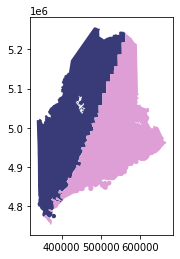

In [ ]:
districts_df = all_districts.dissolve(by="SHUFFLED")
districts_df.plot(cmap="tab20b")

## Step by Step Review

In [ ]:
def split_review(input_df, split, split_cols, plot_party=False, figsize = (8,8), save=None):
    input_df['TEMP_DISTRICT'] = input_df.apply(splits_to_regions_binary, splits=split_columns[:split], axis=1)
    n_districts = input_df['TEMP_DISTRICT'].nunique()
    # random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
    random_districts = np.linspace(0,n_districts-1,n_districts)
    shuffle_dict = dict(zip(input_df["TEMP_DISTRICT"].unique(), random_districts))
    input_df["TEMP_DISTRICT"] = input_df["TEMP_DISTRICT"].apply(lambda x: shuffle_dict[x])

    districts_df = input_df.dissolve(by = "TEMP_DISTRICT", aggfunc={"TEMP_DISTRICT": "first", d_votes: "sum", r_votes: "sum"})
    districts_df["Dem_Ratio"] = districts_df[d_votes]/(districts_df[d_votes] + districts_df[r_votes])
    districts_df["Rep_Ratio"] = districts_df[r_votes]/(districts_df[d_votes] + districts_df[r_votes])

    
    fig, ax = plt.subplots(1,1, figsize=figsize)

    if plot_party:
        base = districts_df.plot(ax=ax, cmap="RdBu", column="Dem_Ratio", legend=True, vmin=0, vmax=1, edgecolor='black')
        dem_wins = districts_df.loc[districts_df["Dem_Ratio"] >= districts_df["Rep_Ratio"]].shape[0]
        rep_wins = districts_df.loc[districts_df["Dem_Ratio"] < districts_df["Rep_Ratio"]].shape[0]
        title = f"Districts: {districts_df.shape[0]} | D-R: {dem_wins}-{rep_wins}"
    else:
        base = districts_df.plot(ax=ax, cmap="tab20b", edgecolor='black')
        title = f"Districts - {districts_df.shape[0]}"
    

    points = []
    for x in range(2**split):
        sub = input_df.loc[input_df['TEMP_DISTRICT'] == x]
        if sub.shape[0] == 0:
            continue
        pop_center_LON = (sub['RP_LON'] * sub[pop]).sum()/sub[pop].sum()
        pop_center_LAT =  (sub['RP_LAT'] * sub[pop]).sum()/sub[pop].sum()
        point = shapely.geometry.Point(pop_center_LON, pop_center_LAT)
        points.append(point)
    pop_center_df = gpd.GeoDataFrame(geometry=points)
    pop_center_df.plot(ax=ax, color="white", linewidth=1.0, edgecolor="black")
    plt.title(title)
    if save:
        fig.savefig(save)
    plt.show()

    return districts_df


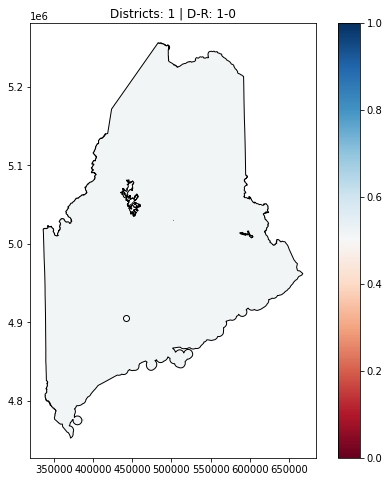

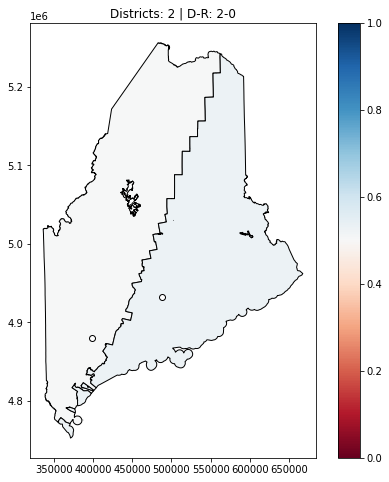

In [ ]:
for s in range(len(split_columns)+1):
    _ = split_review(input_df=all_districts, split=s, split_cols=split_columns, plot_party=True)

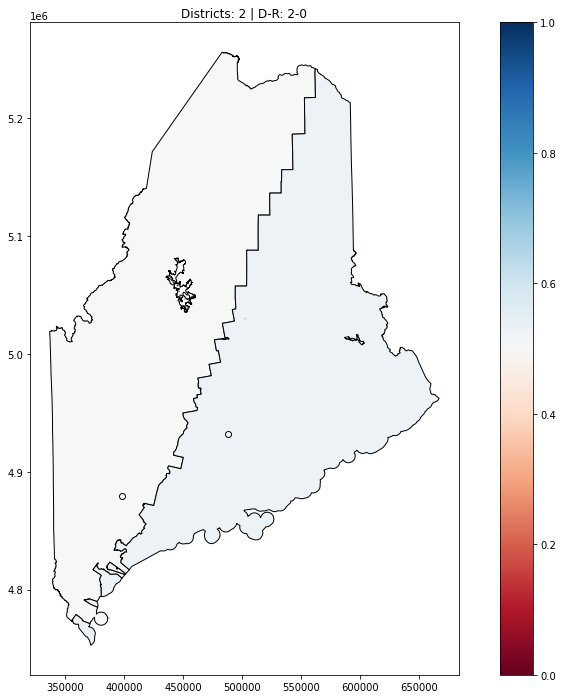

In [ ]:
_ = split_review(input_df=all_districts, split=5, split_cols=split_columns, plot_party=True, figsize=(15,12), save=f"{state}_new.png")